In [2]:
from sortedcontainers import SortedList
from math import sqrt,log,exp,tanh,pi
from scipy.stats import mannwhitneyu,norm

#### approximation for cdf of Normal distribution according to formula 20 in Ramu Yerukala and Naveen Kumar Boiroju "Approximations to Standard Normal Distribution Function" 2015

In [577]:
def cdf_20(z) :
    if abs(z) < 1.0e-10 :
        return z/sqrt(2*pi) 
    return 1.0 - (exp(-z*z/2)/((44/79)+(8/5)*z+(5/6)*sqrt(z*z+3)))

In [5]:
def add(X,Ux,Y,Uy,T,val) :
    lb = X.bisect_left(val)
    rb = X.bisect_right(val)
    t = rb - lb
    lb = Y.bisect_left(val)
    rb = Y.bisect_right(val)
    t = t + rb - lb
    T = T + 3*(t*t + t)   
    if Ux == None :
        Ux = 0.0
    if lb != rb :
        Ux += 0.5*(rb - lb)
    Ux += lb
    X.add(val)  
    if len(Y) > 0 :
        Uy = len(X)*len(Y) - Ux
    return (X,Ux,Y,Uy,T)

In [6]:
def remove(X,Ux,Y,Uy,T,val) :
    X.remove(val)
    lb = X.bisect_left(val)
    rb = X.bisect_right(val)
    t = rb - lb
    lb = Y.bisect_left(val)
    rb = Y.bisect_right(val)
    t = t + rb - lb
    T = T - 3*(t*t + t)  
    if len(X) == 0 :
         Ux = None
    else :
        if lb != rb :
            Ux -= 0.5*(rb - lb)
        Ux -= lb
        if len(Y) > 0 :
            Uy = len(X)*len(Y) - Ux
    return (X,Ux,Y,Uy,T)

In [1367]:
class seq_mann_whitney_U :
    def __init__(self) :
        self.X = SortedList()
        self.Y = SortedList()
        self.Ux = None
        self.Uy = None
        self.T = 0.0
    def add_x(self,val) :
        self.X,self.Ux,self.Y,self.Uy,self.T = add(self.X,self.Ux,self.Y,self.Uy,self.T,val)
    def add_y(self,val) :
        self.Y,self.Uy,self.X,self.Ux,self.T = add(self.Y,self.Uy,self.X,self.Ux,self.T,val)
        return self 
    def remove_x(self,val) :
        self.X,self.Ux,self.Y,self.Uy,self.T = remove(self.X,self.Ux,self.Y,self.Uy,self.T,val)
    def remove_y(self,val) :
        self.Y,self.Uy,self.X,self.Ux,self.T = remove(self.Y,self.Uy,self.X,self.Ux,self.T,val)
    def asymptotic_p(self) :
        if self.Ux == None or self.Uy == None :
            return None
        nx = len(self.X)
        ny = len(self.Y)
        n = nx + ny
        mu = nx*ny/2
        U = self.Ux
        if self.Uy > U :
            U = self.Uy  
        sigma = sqrt((mu/6)*(n+1-self.T/(n*(n-1))))
        if sigma == 0.0 :
            return 1.0
        # return (1-cdf_20((U - mu)/sigma))
        return 2*norm.sf((U - mu)/sigma) 
    def asymptotic_z(self) :
        if self.Ux == None or self.Uy == None :
            return None
        nx = len(self.X)
        ny = len(self.Y)
        n = nx + ny
        mu = nx*ny/2
        U = self.Ux
        if self.Uy > U :
            U = self.Uy  
        sigma = sqrt((mu/6)*(n+1-self.T/(n*(n-1))))
        if sigma == 0.0 :
            return 0.0
        return (U - mu)/sigma
    def asymptotic_log_lik(self) :
        if self.Ux == None or self.Uy == None :
            return None
        nx = len(self.X)
        ny = len(self.Y)
        n = nx + ny
        mu = nx*ny/2
        U = self.Ux
        if self.Uy > U :
            U = self.Uy  
        sigma = sqrt((mu/6)*(n+1-self.T/(n*(n-1))))
        if sigma < 1e-5 :
            sigma = 1e-5
        z = (U-mu)/sigma
        return 2*(1.0-cdf_20((U - mu)/sigma))
        #return 2*norm.sf((U - mu)/sigma)
        # return log(2*norm.sf((U - mu)/sigma))
        # return -log(sigma*sqrt(2*pi))-0.5*z*z

In [6]:
S = seq_mann_whitney_U()

In [7]:
Y = [19,22,16,29,24]
X = [20,11,17,12]

for y in Y :
    S.add_y(y)
for x in X :
    S.add_x(x)

In [8]:
print(S.Ux)
print(S.Uy)
print(S.T)
print(S.asymptotic_p())

3.0
17.0
0.0
0.08625332153592402


In [9]:
from scipy.stats import mannwhitneyu

In [10]:
mannwhitneyu(Y,X,method="asymptotic",use_continuity=False)

MannwhitneyuResult(statistic=17.0, pvalue=0.0864107329737)

In [3]:
from numpy.random import uniform,poisson,seed

In [12]:
seed(1)

In [13]:
X = uniform(0,1,100)
Y = uniform(0,1,100)

In [14]:
S = seq_mann_whitney_U()
for y in Y :
    S.add_y(y)
for x in X :
    S.add_x(x)

In [15]:
print(S.Ux)
print(S.Uy)
print(S.T)
print(S.asymptotic_p())

5024.0
4976.0
0.0
0.953018079084583


In [16]:
mannwhitneyu(X,Y,method="asymptotic",use_continuity=False)

MannwhitneyuResult(statistic=5024.0, pvalue=0.9532377881057771)

In [17]:
seed(1)
X = poisson(1,100)
Y = poisson(1,100)

In [18]:
S = seq_mann_whitney_U()
for y in Y :
    S.add_y(y)
for x in X :
    S.add_x(x)

In [19]:
print(S.Ux)
print(S.Uy)
print(S.T)
print(S.asymptotic_p())

4588.5
5411.5
814770.0
0.2886276802393066


In [20]:
mannwhitneyu(X,Y,method="asymptotic",use_continuity=False)

MannwhitneyuResult(statistic=4588.5, pvalue=0.2887206312324161)

In [21]:
X = uniform(0,1,10)
Y = uniform(0,1,10)

In [22]:
S = seq_mann_whitney_U()
for y in Y :
    S.add_y(y)
for x in X :
    S.add_x(x)

In [23]:
print(S.Ux)
print(S.Uy)
print(S.T)
print(S.asymptotic_p())

70.0
30.0
0.0
0.1303834755668185


In [24]:
mannwhitneyu(X,Y,method="asymptotic",use_continuity=False)

MannwhitneyuResult(statistic=70.0, pvalue=0.1305700181157362)

In [25]:
X = list(X) + [0.5,0.5]
Y = list(Y) + [0.5,0.5]

In [26]:
S = seq_mann_whitney_U()
for y in Y :
    S.add_y(y)
for x in X :
    S.add_x(x)

In [27]:
print(S.Ux)
print(S.Uy)
print(S.T)
print(S.asymptotic_p())

96.0
48.0
60.0
0.1647465861077162


In [28]:
mannwhitneyu(X,Y,method="asymptotic",use_continuity=False)

MannwhitneyuResult(statistic=96.0, pvalue=0.16493532127717858)

## AMOC

In [1198]:
seed(0)
X = list(poisson(1,100)) # + list(poisson(5,1))

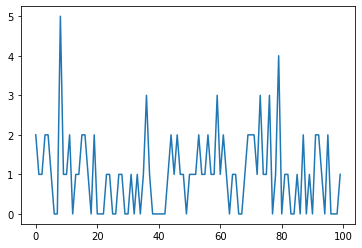

In [1199]:
plt.plot(X)

In [1200]:
S = seq_mann_whitney_U()
for x in X :
    S.add_x(x)

In [1201]:
P = list()

In [1202]:
for y in reversed(X[-20:]) :
    S.add_y(y)
    P.append(S.asymptotic_p())
P = [p for p in reversed(P)]

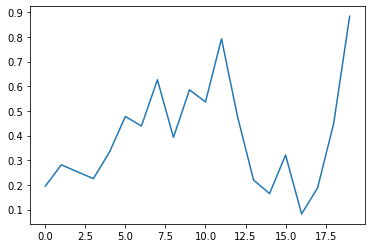

In [1203]:
plt.plot(P)

In [1204]:
[p < 0.1 for p in P]

[False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False]

### without change

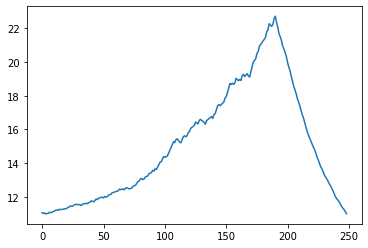

In [974]:
val = [2*log(240) - 2*log(p) for p in reversed(P)]
plt.plot(val)

In [975]:
4*log(210)

21.388430122869874

In [738]:
val.index(max(val))

953

In [389]:

neg_log_lik.index(min(neg_log_lik))

9538

In [487]:
2*log(200)

10.596634733096073

In [441]:
log_lik_alternative

0.0

In [291]:
2*min(neg_log_lik) + 2*log_lik_alternative

-5161.370033140599

### LHS

In [395]:
4*log(10000) + 2*min(neg_log_lik)

-20.545504994806677

### RHS

In [396]:
2*log(10000) + 2*log_lik_alternative

-9.144268308305183

## Find the penalty threshold via rejection of false positives

In [222]:

cut_offs = list()
for i in range(100) :
    X = list(poisson(1,500)) + list(poisson(10,500))
    S = seq_mann_whitney_U()
    for x in X :
        S.add_x(x)
    log_lik_left = list()
    log_lik_right = list()   
    for x in X[:-1] :
        S.add_y(x)
        log_lik_left.append(S.asymptotic_log_lik())
    S.add_y(X[len(X)-1])
    log_lik_alternative = S.asymptotic_log_lik()
    for x in X[:-1] :
        S.remove_y(x)
        log_lik_right.append(S.asymptotic_log_lik())
    # cut_offs.append(max([2*(l + r) for l,r in zip(log_lik_left,log_lik_right)]) - 2*log_lik_alternative)
    cut_offs.append(max([2*(l + r) for l,r in zip(log_lik_left,log_lik_right)]))
    # cut_offs.append(4*log(1000) - 2*max([(l + r) for l,r in zip(log_lik_left,log_lik_right)]) < 2*log(1000) - 2*log_lik_alternative)




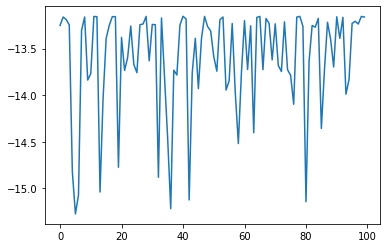

In [223]:
plt.plot(cut_offs)

In [199]:
2*log(1000)

13.815510557964274

In [121]:
X = list(poisson(1,1000))
#X = list(uniform(0,1,4))
S = seq_mann_whitney_U()
for x in X :
    S.add_x(x)
    S.add_y(x)
print(S.asymptotic_log_lik())
        

-10.330086307050747


In [187]:
S.T

831253056.0

In [10]:
import matplotlib.pyplot as plt

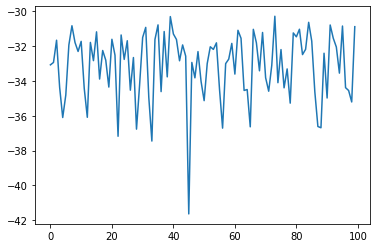

In [29]:
plt.plot(cut_offs)

In [30]:
6*log(200)

31.789904199288216

## Sequential AMOC

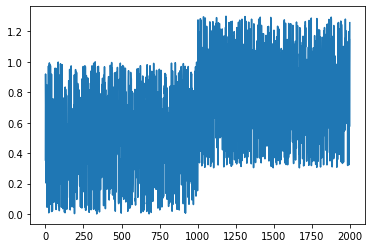

In [387]:
X = list(poisson(1,190)) + list(poisson(1,10))
X = list(uniform(0,1,1000)) + list(uniform(0.3,1.3,1000))
plt.plot(X)

In [388]:
S = seq_mann_whitney_U()
for x in X[0:1] :
    S.add_x(x)
Z = [X[0]]

In [389]:
c = 1
results = list()
for x in X[1:] :
    S.add_x(x)
    Z.append(x)
    log_lik_left = list()
    log_lik_right = list()
    for z in Z[:-1] :
        S.add_y(z)
        log_lik_left.append(S.asymptotic_log_lik())
    S.add_y(Z[len(Z)-1])
    for z in Z[:-1] :
        S.remove_y(z)
        log_lik_right.append(S.asymptotic_log_lik())
    S.remove_y(Z[len(Z)-1])
    log_lik = [l + r for l,r in zip(log_lik_left,log_lik_right)]
    m = min(log_lik)
    c = c + 1
    results.append((m,2*log(len(S.X)),m,c))
        

In [386]:
results

[(-1.6447298858494, 1.3862943611198906, -1.6447298858494, 2),
 (-3.023024100372308, 2.1972245773362196, -3.023024100372308, 3),
 (-4.22857251642447, 2.772588722239781, -4.22857251642447, 4),
 (-5.075068293821441, 3.2188758248682006, -5.075068293821441, 5),
 (-5.17951370265279, 3.58351893845611, -5.17951370265279, 6),
 (-5.55944849498829, 3.8918202981106265, -5.55944849498829, 7),
 (-5.982331658269022, 4.1588830833596715, -5.982331658269022, 8),
 (-6.4674539487955975, 4.394449154672439, -6.4674539487955975, 9),
 (-6.5734067420001026, 4.605170185988092, -6.5734067420001026, 10),
 (-6.8719523944493766, 4.795790545596741, -6.8719523944493766, 11),
 (-7.082218032937163, 4.969813299576001, -7.082218032937163, 12),
 (-7.303666849737008, 5.1298987149230735, -7.303666849737008, 13),
 (-8.063049255041498, 5.278114659230517, -8.063049255041498, 14),
 (-8.528394120585682, 5.41610040220442, -8.528394120585682, 15),
 (-9.10259729602848, 5.545177444479562, -9.10259729602848, 16),
 (-8.706728402999346

## Moving Window AMOC

In [398]:
from collections import deque
X = list(poisson(1,5000)) + list(poisson(1,5000))
winlen = 500
D = deque([],maxlen=winlen)
S = seq_mann_whitney_U()
S.add_x(X[0])
D.append(X[0])
c = 2
results = list()
for x in X[1:] :
    S.add_x(x)
    if len(D) == winlen :
        S.remove_x(D[0])
    D.append(x)
    log_lik_left = list()
    log_lik_right = list()
    for i in range(1,len(D)) :
        S.add_y(D[i])
        log_lik_left.append(S.asymptotic_log_lik())
    S.add_y(D[len(D)-1])
    for i in range(1,len(D)) :
        S.remove_y(D[i])
        log_lik_right.append(S.asymptotic_log_lik())
    S.remove_y(D[len(D)-1])
    log_lik = [l + r for l,r in zip(log_lik_left,log_lik_right)]
    m = min(log_lik)
    c = c + 1
        # print(m,2*log(len(S.X)),log_lik.index(m),c)
    results.append((m,2*log(len(S.X)),log_lik.index(m),c))
    
        

In [ ]:
positions = [c for x,y,p,c in results if -x > y and p == results[len(results)-1][2]]
    if len(positions) > 0 :
        print(positions[0],results[len(results)-1][2])
        summary.append((positions[0],results[len(results)-1][2]))
    else :
        print(None,None)
        summary.append((None,None))

In [71]:
summary

[(140, 114),
 (153, 99),
 (155, 105),
 (None, None),
 (201, 84),
 (146, 100),
 (None, None),
 (152, 135),
 (151, 104),
 (116, 99)]

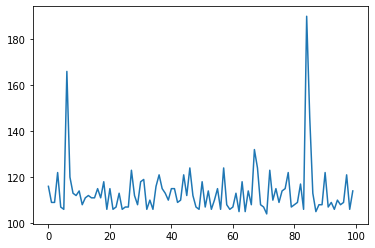

In [583]:
plt.plot([f for f,_ in summary if f != None])

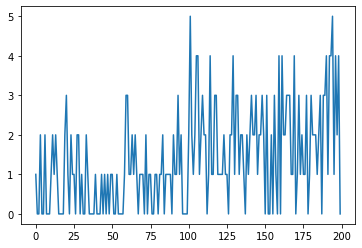

In [53]:
X = list(poisson(1,100)) + list(poisson(2,100))
# X = list(uniform(0,1,1000)) + list(uniform(0.2,1.2,1000))
plt.plot(X)

In [54]:
from collections import deque

In [55]:
winlen = 500
D = deque([],maxlen=winlen)
S = seq_mann_whitney_U()

In [56]:
S.add_x(X[0])
D.append(X[0])

In [57]:
c = 2
results = list()
for x in X[1:] :
    S.add_x(x)
    if len(D) == winlen :
        S.remove_x(D[0])
    D.append(x)
    p_left = list()
    p_right = list()
    for i in range(1,len(D)) :
        S.add_y(D[i])
        p_left.append(S.asymptotic_p())
    S.add_y(D[len(D)-1])
    for i in range(1,len(D)) :
        S.remove_y(D[i])
        p_right.append(S.asymptotic_p())
    S.remove_y(D[len(D)-1])
    log_lik = [log(pl) + log(pr) for pl,pr in zip(p_left,p_right)]
    m = min(log_lik)
    c = c + 1
    # print(m,2*log(len(S.X)),log_lik.index(m),c)
    results.append((m,2*log(len(S.X)),log_lik.index(m),c))

In [63]:
[c for x,y,p,c in results if -x > y and p == results[len(results)-1][2]][0]

107

In [50]:
results

[(-1.4700222596741688, 1.3862943611198906, 0, 2),
 (-1.6729664636584687, 2.1972245773362196, 1, 3),
 (-0.7913010493597109, 2.772588722239781, 1, 4),
 (-2.258446633249434, 3.2188758248682006, 2, 5),
 (-1.7550260272541112, 3.58351893845611, 2, 6),
 (-2.009985965258151, 3.8918202981106265, 2, 7),
 (-2.2388320011701532, 4.1588830833596715, 2, 8),
 (-1.8839029450284794, 4.394449154672439, 6, 9),
 (-2.6621782572458765, 4.605170185988092, 7, 10),
 (-3.475008729063638, 4.795790545596741, 8, 11),
 (-1.3238232235183651, 4.969813299576001, 2, 12),
 (-3.181620563903213, 5.1298987149230735, 10, 13),
 (-2.718918860814834, 5.278114659230517, 8, 14),
 (-2.964623835659636, 5.41610040220442, 8, 15),
 (-3.1970981446446265, 5.545177444479562, 8, 16),
 (-3.4191499528623215, 5.666426688112432, 8, 17),
 (-3.6326081671399653, 5.780743515792329, 8, 18),
 (-3.838779391743758, 5.8888779583328805, 8, 19),
 (-4.7312220854702645, 5.991464547107982, 8, 20),
 (-4.3834195938659155, 6.089044875446846, 8, 21),
 (-3.3040

In [51]:
import NUNC_module as NUNC

In [606]:
for i in range(100) :
    X = list(poisson(1,100)) + list(poisson(2,100))
    n = 2000
    w = 100
    k =10
    threshold = 4.0*log(w)
    NUNC_run = NUNC.nunc_local(X, k, w, threshold)
    print(NUNC_run[0:3])

(-1, -1, 18.393916667966764)
(-1, -1, 17.23419828312708)
(-1, -1, 18.05684106954582)
(130, 146, 19.466136732817027)
(-1, -1, 17.268748980038936)
(106, 116, 19.10528304484518)
(-1, -1, 14.011099266381876)
(102, 118, 19.52753706014225)
(-1, -1, 17.286504803635864)
(125, 142, 19.09428406220512)
(119, 133, 19.94425261445903)
(128, 142, 19.651173267451753)
(20, 107, 20.32514467294729)
(117, 132, 20.448582249968226)
(112, 133, 18.880307497223484)
(136, 158, 19.241080544248916)
(113, 128, 20.31624173414209)
(105, 114, 19.438805678008833)
(101, 111, 19.926267489369508)
(93, 106, 18.56549112715664)
(-1, -1, 17.949079072421803)
(111, 130, 18.931341957867573)
(80, 102, 20.169034491451754)
(91, 106, 18.51265595199917)
(140, 158, 19.072855456763257)
(98, 125, 18.926851355133024)
(-1, -1, 17.866354737834826)
(168, 184, 19.109762943187988)
(170, 188, 18.491432735999766)
(-1, -1, 17.300951469832064)
(102, 111, 18.762575502414677)
(123, 142, 21.07088015086675)
(-1, -1, 15.877304460501875)
(132, 144, 20

In [75]:
NUNC_run[0:3]

(-1, -1, 8.11752651843689)

### check correction

In [ ]:
X = list(poisson(1,1000))
Y = list(poisson(2,1000))

In [ ]:
mannwhitneyu(X,Y,method="asymptotic",use_continuity=False)

In [ ]:
S = seq_mann_whitney_U()
for y in Y :
    S.add_y(y)
for x in X :
    S.add_x(x)

In [ ]:
print(S.Ux)
print(S.Uy)
print(S.asymptotic_p())

In [ ]:
for x in X[100:] :
    S.remove_x(x)

In [ ]:
print(S.Ux)
print(S.Uy)
print(S.asymptotic_p())

In [ ]:
mannwhitneyu(X[:100],Y,method="asymptotic",use_continuity=False)

In [ ]:
log(S.asymptotic_p())

In [ ]:
[4,3,2,1,2,1,4].index(1)

### infinite window AMOC

In [1077]:
class IW_AMOC :
    def __init__(self) :
        self.X = list()
        self.alarm = False
        self.min_p = None
    def add(self,x) :
        self.X.append(x)
        self.S = seq_mann_whitney_U()
        self.location = None
        for x in self.X :
            self.S.add_x(x)
        P = list()
        for y in reversed(self.X) :
            self.S.add_y(y)
            P.append(self.S.asymptotic_p())
        P = [p for p in reversed(P)]
        if len(P) == 0 :
            return self
        min_p = min(P)
        self.min_p = min_p
        if min_p < 0.001 :
            self.alarm = True
            self.location = P.index(min_p)
        return self
        
        
            
    
                
        

In [1081]:
X = list(uniform(0,1,1000)) + list(uniform(2,3,1000))
W = IW_AMOC()
i = 1
for x in X :
    W.add(x)
    print(W.min_p)
    if len(W.X) > 100 :
        if W.alarm == True :
            print("Alarm at ",i," located at ",W.location, )
    W.alarm = False
    i += 1
    

1.0
0.4795001221869535
0.5428024537573732
0.27650048008343264
0.23476366282766925
0.20719629817229768
0.1877812720991524
0.18899172177040735
0.26473683413197024
0.15379037392108486
0.25550882029402844
0.2595739093654976
0.2563491458441918
0.2461215343464206
0.3097849939989765
0.26127981237143116
0.2936215439289058
0.3150901079796382
0.1184329289166719
0.36062189023261093
0.33666002029794984
0.2551836363766835
0.3859602918338896
0.40127041881322845
0.42016538740181064
0.4377338509484838
0.44165773369729255
0.40563701022903476
0.44978994244671244
0.464497736855789
0.365177706275153
0.37198937959448464
0.12624996943446581
0.2548076830148349
0.3357062023331796
0.2663762544814362
0.47214350042160247
0.26669304262224414
0.40633661547921474
0.2625239861770545
0.17503336967070138
0.333768584420702
0.4336360483639695
0.46196199308835895
0.22811572512326939
0.09716215581664438
0.33700379339592246
0.1137928102267599
0.06899977912680326
0.04489301146086876
0.1826559957720808
0.17767167789202432
0.

0.09090957572181423
0.12134823659113653
0.13636869876259355
0.11556936683407303
0.08937379382490566
0.09824007823855119
0.02972380704135218
0.013827312358511088
0.08673148423038216
0.043705702727150776
0.0420872539552428
0.10197787989207252
0.09053276760411527
0.0981708821420035
0.10170979903725423
0.1098678311462318
0.10413776088331857
0.12338686952523728
0.11389708362759984
0.11159799098643894
0.10262807980200063
0.12094699121548382
0.06170533067635969
0.14408413924526473
0.13400326672645888
0.1426343979670521
0.09654550072394587
0.1585706958220865
0.1203245580401875
0.04397380230809908
0.06903194370214642
0.14373455395221504
0.1497760889116666
0.1308627623760422
0.2082452640081176
0.21220459134734426
0.20063055379742822
0.09773786723661926
0.17976460014088835
0.23052203023178097
0.20737626958766497
0.09630055584181657
0.12385570330295764
0.20965841199983826
0.20770570599940663
0.21116386052931935
0.22887954347659767
0.21046739861264452
0.21269460350826352
0.18795315969298254
0.21367

0.1807890555693088
0.22962580675541988
0.22418522126362872
0.21160586158838823
0.07558784986002276
0.1858252435795773
0.06678967143493901
0.08221576348167094
0.022948819065862328
0.03259425765891282
0.02126281917533503
0.006256382592953493
0.038845921828620913
0.020218602965076278
0.0689622449072177
0.05164869253832031
0.07390808469285728
0.09450986967860968
0.0561935772619749
0.08815884993217106
0.10807827529871036
0.0946028676005221
0.09398791985214391
0.13489178338193664
0.14872326474636618
0.16965675684405146
0.14267996486558507
0.11461644185521633
0.15285946574740344
0.050312338218798484
0.07621142698605643
0.18279900535986127
0.11639692889783887
0.08842647632009579
0.190193553560984
0.15983159401071234
0.168799201476581
0.19825049968497732
0.2053836272354821
0.2253026486425196
0.20725225574840844
0.23331577884883514
0.25329798700329187
0.236213681956579
0.10689126402686036
0.20948817705964295
0.2213004077876427
0.11945694332887438
0.0369849996456211
0.19649839358969323
0.13727244

9.357562856640718e-45
Alarm at  1083  located at  1000
3.695426869861283e-45
Alarm at  1084  located at  1000
1.4670364140226425e-45
Alarm at  1085  located at  1000
5.854327375172473e-46
Alarm at  1086  located at  1000
2.3483265019385993e-46
Alarm at  1087  located at  1000
9.468277508021831e-47
Alarm at  1088  located at  1000
3.837074976421117e-47
Alarm at  1089  located at  1000
1.5629040134612001e-47
Alarm at  1090  located at  1000
6.39813010447627e-48
Alarm at  1091  located at  1000
2.6323807814160313e-48
Alarm at  1092  located at  1000
1.0884425217303336e-48
Alarm at  1093  located at  1000
4.5228252461691185e-49
Alarm at  1094  located at  1000
1.8886353911404065e-49
Alarm at  1095  located at  1000
7.925141919126134e-50
Alarm at  1096  located at  1000
3.341744881134719e-50
Alarm at  1097  located at  1000
1.4159035584048753e-50
Alarm at  1098  located at  1000
6.028026043026069e-51
Alarm at  1099  located at  1000
2.578604072662502e-51
Alarm at  1100  located at  1000
1.1

4.372674233632959e-87
Alarm at  1239  located at  1000
2.942697229550385e-87
Alarm at  1240  located at  1000
1.9845899582183183e-87
Alarm at  1241  located at  1000
1.3412751494399582e-87
Alarm at  1242  located at  1000
9.084102037694693e-88
Alarm at  1243  located at  1000
6.165358763961992e-88
Alarm at  1244  located at  1000
4.1931668493341315e-88
Alarm at  1245  located at  1000
2.8577788692460227e-88
Alarm at  1246  located at  1000
1.951699988853135e-88
Alarm at  1247  located at  1000
1.335644144880026e-88
Alarm at  1248  located at  1000
9.15919000705527e-89
Alarm at  1249  located at  1000
6.29371876613756e-89
Alarm at  1250  located at  1000
4.3334814970277626e-89
Alarm at  1251  located at  1000
2.989794427352632e-89
Alarm at  1252  located at  1000
2.066883140696187e-89
Alarm at  1253  located at  1000
1.4317137767690593e-89
Alarm at  1254  located at  1000
9.937054518837957e-90
Alarm at  1255  located at  1000
6.910601602058331e-90
Alarm at  1256  located at  1000
4.8153

8.645125942958128e-105
Alarm at  1390  located at  1000
7.290671874655925e-105
Alarm at  1391  located at  1000
6.1546235668218195e-105
Alarm at  1392  located at  1000
5.200811300291324e-105
Alarm at  1393  located at  1000
4.399206123243062e-105
Alarm at  1394  located at  1000
3.724852712762289e-105
Alarm at  1395  located at  1000
3.1569917978582758e-105
Alarm at  1396  located at  1000
2.6783377651320266e-105
Alarm at  1397  located at  1000
2.2744834271566432e-105
Alarm at  1398  located at  1000
1.9334090941218564e-105
Alarm at  1399  located at  1000
1.6450772812842893e-105
Alarm at  1400  located at  1000
1.401097793319496e-105
Alarm at  1401  located at  1000
1.194450700889263e-105
Alarm at  1402  located at  1000
1.0192569848146264e-105
Alarm at  1403  located at  1000
8.705884662321907e-106
Alarm at  1404  located at  1000
7.443101454088606e-106
Alarm at  1405  located at  1000
6.369493008881788e-106
Alarm at  1406  located at  1000
5.455867056775572e-106
Alarm at  1407  lo

6.039317147135014e-112
Alarm at  1540  located at  1000
5.682587451806915e-112
Alarm at  1541  located at  1000
5.349660946302304e-112
Alarm at  1542  located at  1000
5.038801570944332e-112
Alarm at  1543  located at  1000
4.748409406084287e-112
Alarm at  1544  located at  1000
4.477009317586081e-112
Alarm at  1545  located at  1000
4.223240601701606e-112
Alarm at  1546  located at  1000
3.985847537058157e-112
Alarm at  1547  located at  1000
3.763670760374262e-112
Alarm at  1548  located at  1000
3.5556393905179225e-112
Alarm at  1549  located at  1000
3.360763832734909e-112
Alarm at  1550  located at  1000
3.178129201367565e-112
Alarm at  1551  located at  1000
3.0068893052179747e-112
Alarm at  1552  located at  1000
2.846261144994731e-112
Alarm at  1553  located at  1000
2.6955198770174413e-112
Alarm at  1554  located at  1000
2.553994201660162e-112
Alarm at  1555  located at  1000
2.42106213886102e-112
Alarm at  1556  located at  1000
2.2961471565400005e-112
Alarm at  1557  locate

6.900387201909744e-114
Alarm at  1690  located at  1000
6.870125705860979e-114
Alarm at  1691  located at  1000
6.841830370015126e-114
Alarm at  1692  located at  1000
6.81547022199156e-114
Alarm at  1693  located at  1000
6.791016085533474e-114
Alarm at  1694  located at  1000
6.768440528877204e-114
Alarm at  1695  located at  1000
6.747717816043962e-114
Alarm at  1696  located at  1000
6.728823860937666e-114
Alarm at  1697  located at  1000
6.71173618412556e-114
Alarm at  1698  located at  1000
6.696433872203615e-114
Alarm at  1699  located at  1000
6.682897539646072e-114
Alarm at  1700  located at  1000
6.67110929303236e-114
Alarm at  1701  located at  1000
6.661052697588769e-114
Alarm at  1702  located at  1000
6.65271274592643e-114
Alarm at  1703  located at  1000
6.646075828936411e-114
Alarm at  1704  located at  1000
6.641129708738197e-114
Alarm at  1705  located at  1000
6.637863493624957e-114
Alarm at  1706  located at  1000
6.636267614943631e-114
Alarm at  1707  located at  1

3.8586890579158876e-113
Alarm at  1837  located at  1000
3.956279929101867e-113
Alarm at  1838  located at  1000
4.0569207606632003e-113
Alarm at  1839  located at  1000
4.1607158138283435e-113
Alarm at  1840  located at  1000
4.267773197730341e-113
Alarm at  1841  located at  1000
4.378205019311109e-113
Alarm at  1842  located at  1000
4.492127539342103e-113
Alarm at  1843  located at  1000
4.6096613348304045e-113
Alarm at  1844  located at  1000
4.7309314680648755e-113
Alarm at  1845  located at  1000
4.8560676625993424e-113
Alarm at  1846  located at  1000
4.985204486460005e-113
Alarm at  1847  located at  1000
5.11848154288516e-113
Alarm at  1848  located at  1000
5.256043668924228e-113
Alarm at  1849  located at  1000
5.398041142223514e-113
Alarm at  1850  located at  1000
5.544629896352818e-113
Alarm at  1851  located at  1000
5.695971745044402e-113
Alarm at  1852  located at  1000
5.85223461571209e-113
Alarm at  1853  located at  1000
6.013592792667788e-113
Alarm at  1854  locat

5.3523520836852794e-111
Alarm at  1984  located at  1000
5.573907996365748e-111
Alarm at  1985  located at  1000
5.8050687267397316e-111
Alarm at  1986  located at  1000
6.0462657749741114e-111
Alarm at  1987  located at  1000
6.2979505971410074e-111
Alarm at  1988  located at  1000
6.560595550766281e-111
Alarm at  1989  located at  1000
6.834694886126419e-111
Alarm at  1990  located at  1000
7.120765785520503e-111
Alarm at  1991  located at  1000
7.419349452900635e-111
Alarm at  1992  located at  1000
7.731012256329883e-111
Alarm at  1993  located at  1000
8.056346925883694e-111
Alarm at  1994  located at  1000
8.395973809727063e-111
Alarm at  1995  located at  1000
8.750542191245629e-111
Alarm at  1996  located at  1000
9.120731670245417e-111
Alarm at  1997  located at  1000
9.50725361139344e-111
Alarm at  1998  located at  1000
9.910852663228097e-111
Alarm at  1999  located at  1000
1.033230835123648e-110
Alarm at  2000  located at  1000


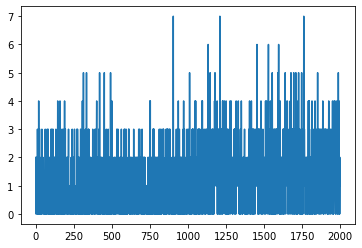

In [1073]:
plt.plot(X)

In [891]:
S = seq_mann_whitney_U()
for x in X :
    S.add_x(x)
    S.add_y(x)

In [892]:
S.asymptotic_p()

1.0

In [1148]:
X = [1,2,3,4]
for x in reversed(X[-2:]) :
    print(x)

4
3


In [1147]:
X[-()():]

[3, 4]

### online change detection

In [1240]:
from collections import deque

In [1365]:
class ocd :
    def __init__(self,n,m) :
        self.D = list()
        self.test = seq_mann_whitney_U()
        self.Ux = None
        self.Uy = None
        self.T = None
        self.alarm = False
        self.Z = list()
        self.n = n
        self.m = m
    def add(self,x) :
        if len(self.D) == self.n :
            self.test.remove_x(self.D.pop(0))
        self.D.append(x)
        self.test.add_x(x)
        self.Ux = self.test.Ux
        self.Uy = self.test.Uy
        self.T = self.test.T
        self.Z = list()
        cut = self.m if len(self.D) > self.m else 0 
        for y in reversed(self.D[-cut:]) :
            self.test.add_y(y)
            self.Z.append(self.test.asymptotic_z())
        self.Z = [z for z in reversed(self.Z)]
        self.test.Ux = self.Ux
        self.test.Uy = self.Uy
        self.test.T = self.T
        self.test.Y = SortedList()
        
        
        

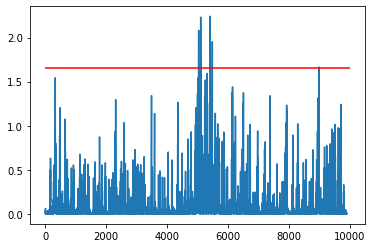

In [1445]:
seed(4)
n = 2000
m = 100
S = ocd(n,m)
X = list(uniform(0,1,10000))#    + list(uniform(1,2,2000))
X = list(uniform(0,1,5000))    + list(uniform(0.1,1.1,5000))
c = 0
minz = list()
for x in X :
    c = c + 1
    S.add(x)
    if len(S.Z) == m :
        minz.append(min(S.Z[:-1]))
    #if len(S.Z) == m and min(S.Z[:-1]) > 1.645 :
    #    print("alarm !!")
    #    print("detected at ",c)
    #    break
plt.plot(minz)
plt.hlines(1.65,0,10000, color='red')

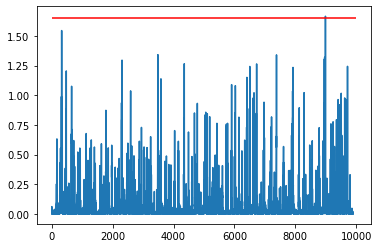

In [1447]:
seed(4)
n = 2000
m = 100
S = ocd(n,m)
X = list(uniform(0,1,10000))#    + list(uniform(1,2,2000))
X = list(uniform(0,1,5000))    + list(uniform(0,1,5000))
c = 0
minz = list()
for x in X :
    c = c + 1
    S.add(x)
    if len(S.Z) == m :
        minz.append(min(S.Z[:-1]))
    #if len(S.Z) == m and min(S.Z[:-1]) > 1.645 :
    #    print("alarm !!")
    #    print("detected at ",c)
    #    break
plt.plot(minz)
plt.hlines(1.65,0,10000, color='red')

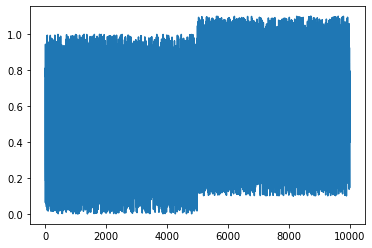

In [1435]:
plt.plot(X)


In [1255]:
X

[0.5488135039273248,
 0.7151893663724195,
 0.6027633760716439,
 0.5448831829968969,
 0.4236547993389047,
 0.6458941130666561,
 0.4375872112626925,
 0.8917730007820798,
 0.9636627605010293,
 0.3834415188257777,
 0.7917250380826646,
 0.5288949197529045,
 0.5680445610939323,
 0.925596638292661,
 0.07103605819788694,
 0.08712929970154071,
 0.02021839744032572,
 0.832619845547938,
 0.7781567509498505,
 0.8700121482468192,
 0.978618342232764,
 0.7991585642167236,
 0.46147936225293185,
 0.7805291762864555,
 0.11827442586893322,
 0.6399210213275238,
 0.1433532874090464,
 0.9446689170495839,
 0.5218483217500717,
 0.4146619399905236,
 0.26455561210462697,
 0.7742336894342167,
 0.45615033221654855,
 0.5684339488686485,
 0.018789800436355142,
 0.6176354970758771,
 0.6120957227224214,
 0.6169339968747569,
 0.9437480785146242,
 0.6818202991034834,
 0.359507900573786,
 0.43703195379934145,
 0.6976311959272649,
 0.06022547162926983,
 0.6667667154456677,
 0.6706378696181594,
 0.2103825610738409,
 0.128

In [1256]:
S.test.X

SortedList([0.004695476192547066, 0.018789800436355142, 0.020107546187493552, 0.02021839744032572, 0.039187792254320675, 0.06022547162926983, 0.06414749634878436, 0.07103605819788694, 0.08712929970154071, 0.09394051075844168, 0.09609840789396307, 0.09710127579306127, 0.10204481074802807, 0.11037514116430513, 0.11827442586893322, 0.11872771895424405, 0.1201965612131689, 0.1289262976548533, 0.13179786240439217, 0.1381829513486138, 0.1433532874090464, 0.15896958364551972, 0.16130951788499626, 0.18319136200711683, 0.1965823616800535, 0.2088767560948347, 0.2103825610738409, 0.24442559200160274, 0.2532916025397821, 0.26455561210462697, 0.2653894909394454, 0.2828069625764096, 0.2894060929472011, 0.29614019752214493, 0.31542835092418386, 0.317983179393976, 0.31856895245132366, 0.359507900573786, 0.3637107709426226, 0.3687251706609641, 0.3834415188257777, 0.41426299451466997, 0.4146619399905236, 0.4236547993389047, 0.43703195379934145, 0.4375872112626925, 0.43860151346232035, 0.4561503322165485

In [1228]:
S.P

[0.36567557728067157,
 0.4183855990346359,
 0.26008486183084967,
 0.4164258966915624,
 0.20355472324431234,
 0.25592707645782775,
 0.407523267094526,
 0.23542001105222532,
 0.7537004486831312,
 0.08953778716103812]

In [1247]:
X.append(2)

In [1267]:
X = [1,2,3,4]

In [1268]:
X.pop(0)

1

In [1270]:
X.append(5)

In [1419]:
2*norm.sf(2.3)

0.021448220043351618

In [1362]:
X = list(uniform(0,1,1000))

for i in range(100) :
    for j in range(5,100) :
        mannwhitneyu(X,X[-j:],method="asymptotic",use_continuity=False)

In [1347]:
Z = [1,2,3,4]
Z[-3:]

[2, 3, 4]